### Import packages

In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import numpy as np
import datetime
from IPython.display import Image
import datetime

### Problem summary

There are 2 main datasets that contain a list of unique credit cards and the target variable to predict:
- *Train.csv*
- *Test.csv*: target variable missing and it is what we want to predict

Then, there are 2 datasets that contain information about all transactions of these cards buying from different merchants:
- *historical_transactions.csv*
- *new_merchant_transactions.csv*

Lastly, there is 1 dataset that contains information about the merchants:
- *merchants.csv*

Basically, this notebook adds the merchants information to all transactions, groups all transactions information by unique credit cards, and merges it with the datasets of unique credit cards for training the model and predict the test set. All this while doing the feature engineering at each step.

Here you can find the scheme of the problem I did in my blackboard :)

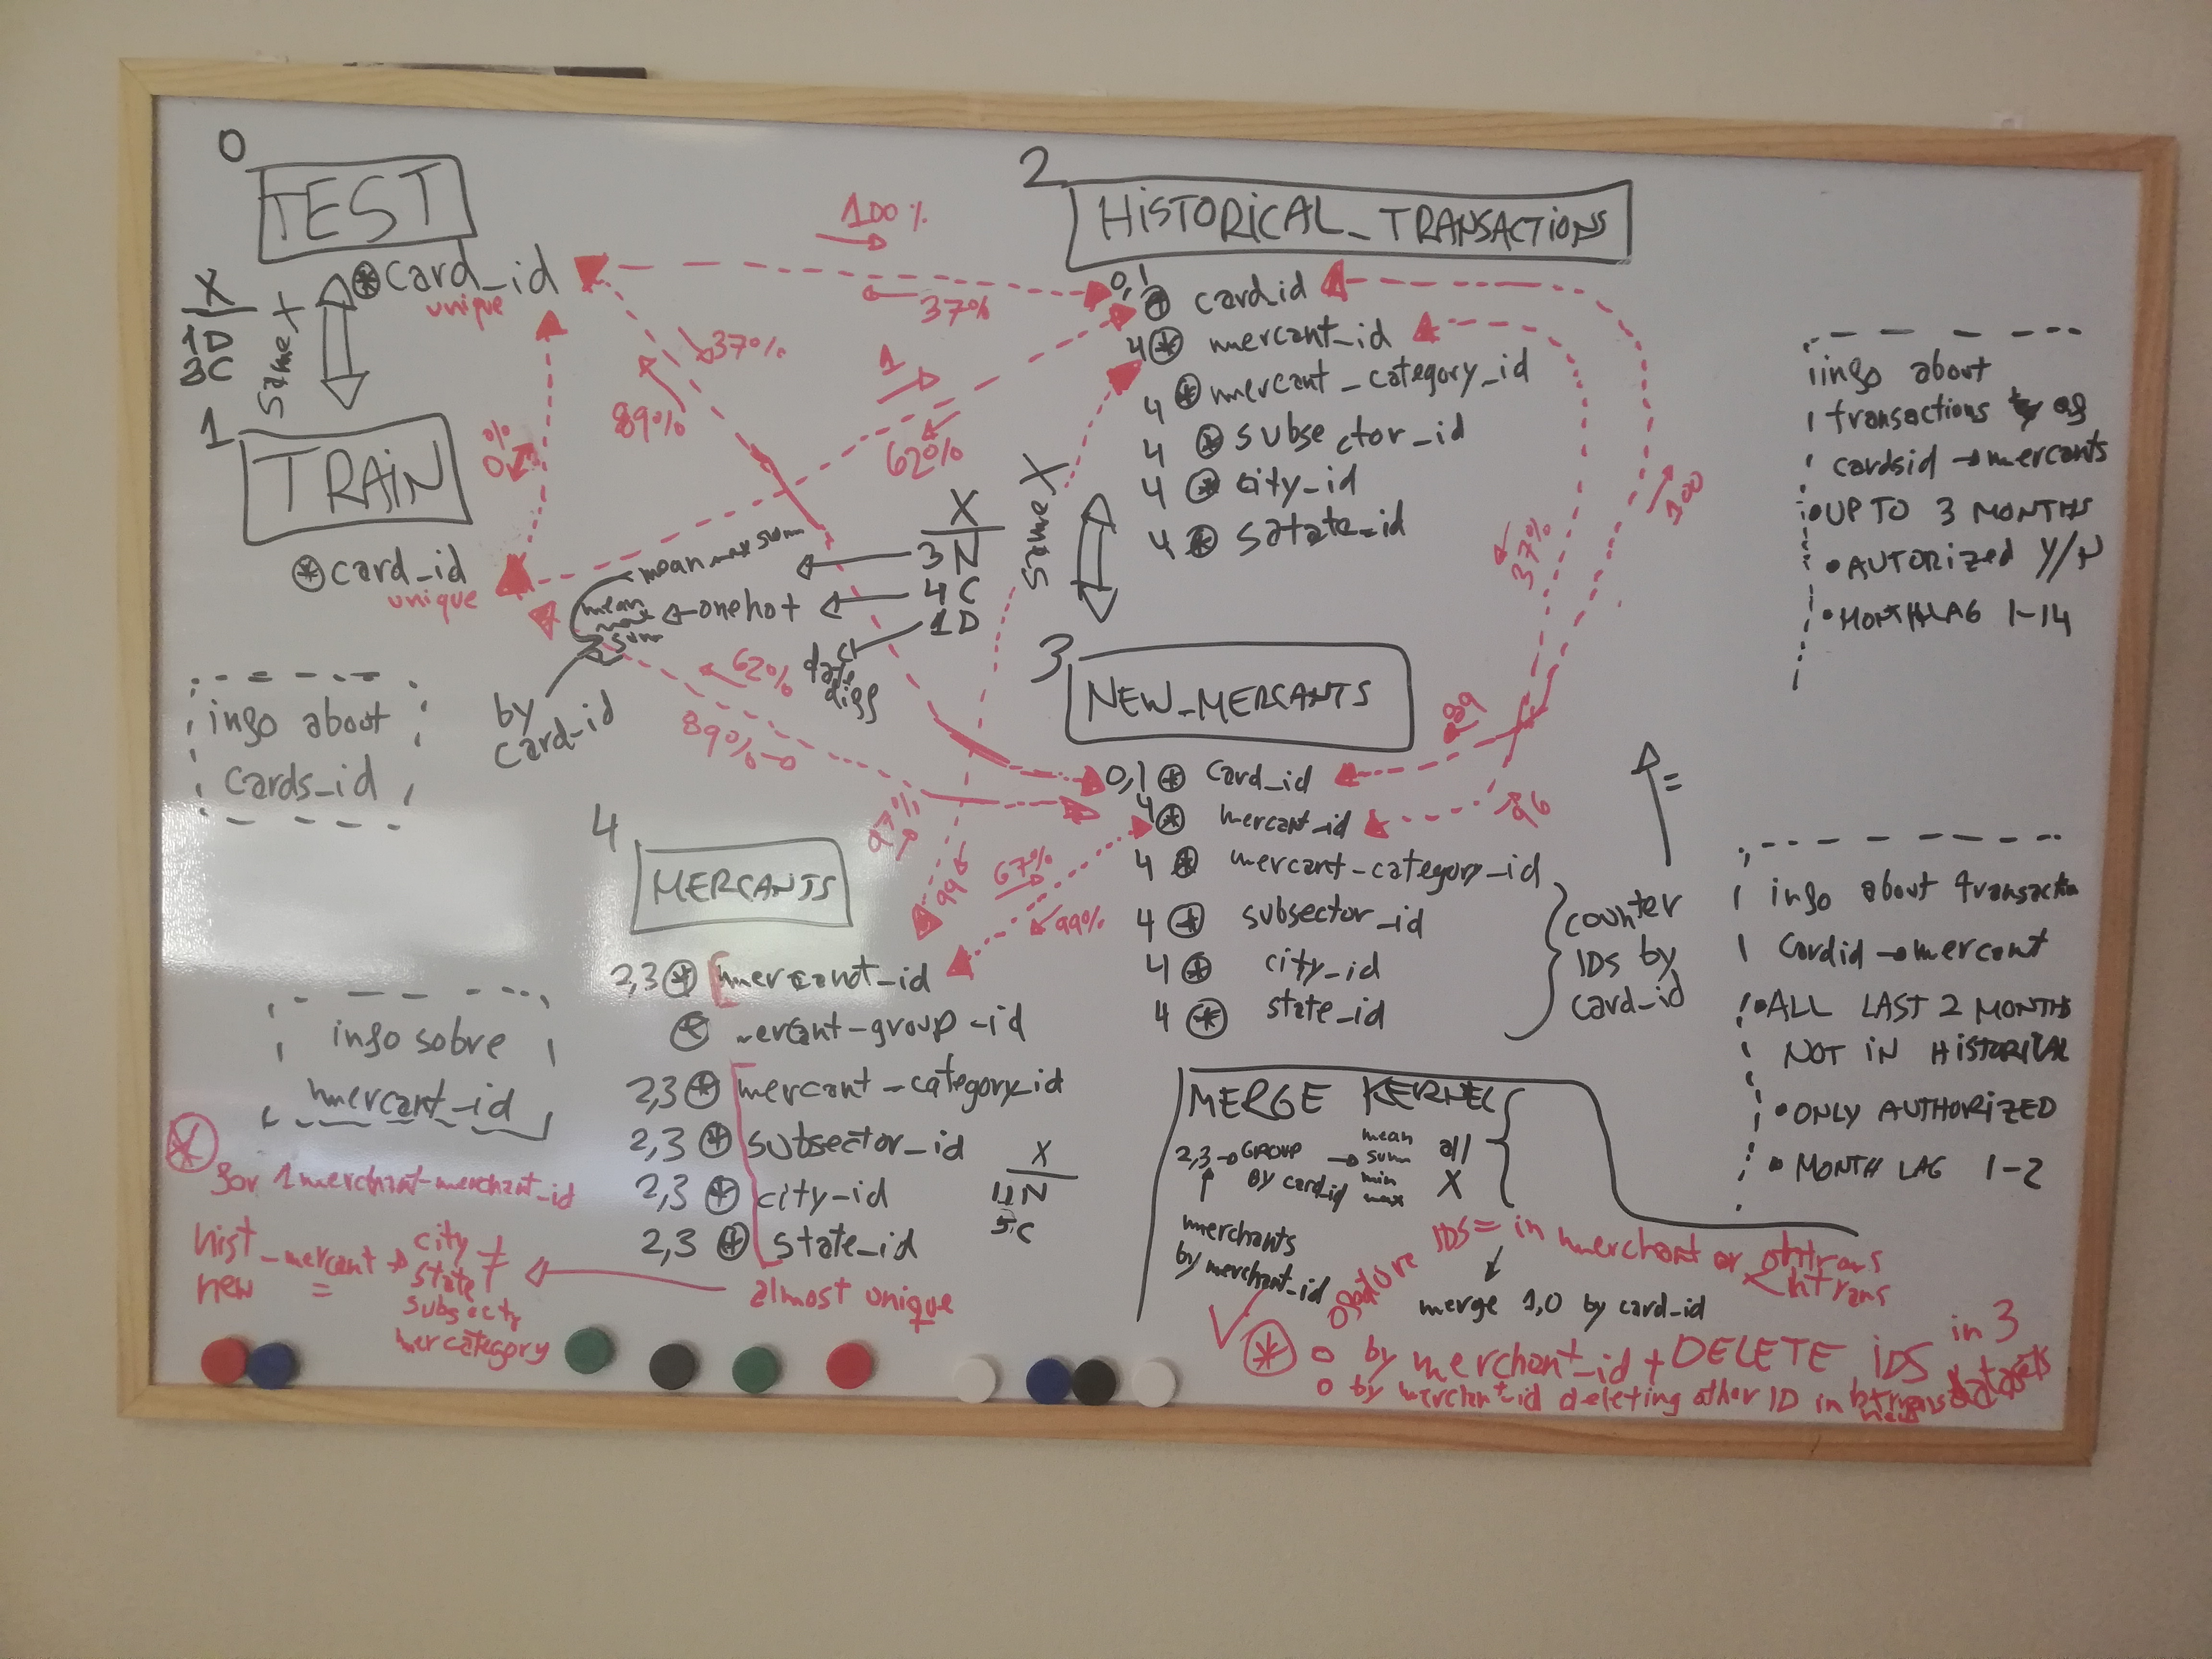

In [2]:
Image(filename='Blackboard.jpg')

### 1. Preprocessing merchants.csv: aggregate by *merchant_id* (mean if numerical feature and mode if not)

In [3]:
merchants = pd.read_csv('Data/merchants.csv')

Impute infinite values by the feature maximum.

In [4]:
features_inf = ["avg_purchases_lag3","avg_purchases_lag6","avg_purchases_lag12"]
for col in features_inf:
    merchants.loc[merchants[col]==np.inf,col] = max(merchants.loc[merchants[col]!=np.inf,col])

Impute missings:
- Numerical features: not necessary because when merging to transactions datasets and grouping them by credit cards, the missings will disappear and if not we will do final imputation by -9999
- Non-numerical features: new level "-9999"

In [5]:
values = {"category_2":-9999}
merchants.fillna(value=values,inplace=True)

Aggregating by *merchant_id* since there are some duplicated *merchants_id* with different features values:
- Numerical features: mean (without missings)
- Non-numerical features: mode

In [6]:
start = datetime.datetime.now()

mode2 = lambda x: mode(x).mode[0]
merchants = merchants.groupby("merchant_id",as_index=False).agg({
    "merchant_group_id": mode2,
    "merchant_category_id": mode2,
    "subsector_id": mode2,
    "numerical_1": "mean",
    "numerical_2": "mean",
    "category_1": mode2,
    "most_recent_sales_range": mode2,
    "most_recent_purchases_range": mode2,
    "avg_sales_lag3": "mean",
    "avg_purchases_lag3": "mean",
    "active_months_lag3": mode2,
    "avg_sales_lag6": "mean",
    "avg_purchases_lag6": "mean",
    "active_months_lag6": mode2,
    "avg_sales_lag12": "mean",
    "avg_purchases_lag12": "mean",
    "active_months_lag12": mode2,
    "category_4": mode2,
    "city_id": mode2,
    "state_id": mode2,
    "category_2": mode2
})

end = datetime.datetime.now()
print("Duration: ",(end-start).seconds/60," minutes")

Duration:  7.55  minutes


Define the types of features.

In [7]:
# Object
features_obj = ["merchant_id","merchant_group_id","merchant_category_id","subsector_id","city_id",
                "state_id"]
for col in features_obj:
    merchants[col] = merchants[col].astype(object)

# Integer
features_int = ["active_months_lag3","active_months_lag6","active_months_lag12"]
for col in features_int:
    merchants[col] = merchants[col].astype("int32")

# Float
features_float = ["numerical_1","numerical_2","avg_sales_lag3","avg_purchases_lag3","avg_sales_lag6",
                  "avg_purchases_lag6","avg_sales_lag12","avg_purchases_lag12"]
for col in features_float:
    merchants[col] = merchants[col].astype("float32")

# Category
levels = {"category_1":["N","Y","-9999"],"category_2":[1,2,3,4,5,-9999],"category_4":["N","Y","-9999"],
          "most_recent_sales_range":["A","B","C","D","E","-9999"],
          "most_recent_purchases_range":["A","B","C","D","E","-9999"]}
features_cat = ["category_1","category_4","most_recent_sales_range","most_recent_purchases_range",
                "category_2"]
for col in features_cat:
    merchants[col] = merchants[col].astype("category",categories=levels[col])

Save the preprocessed *merchants.csv* in python pickle file.

In [8]:
merchants.to_pickle("Data/merchants.pkl")

### 2. Preprocessing historical_transactions.csv

In [9]:
historical_transactions = pd.read_csv('Data/historical_transactions.csv')

Impute missings:
- Numerical features: no missings
- Non-numerical features: new level "-9999"

In [10]:
values = {"category_3":"-9999", "merchant_id": "-9999","category_2":-9999}
historical_transactions.fillna(value=values,inplace=True)

Define the types of features.

In [11]:
# Object
features_obj = ["card_id","merchant_category_id","subsector_id","merchant_id","city_id","state_id"]
for col in features_obj:
    historical_transactions[col] = historical_transactions[col].astype(object)

# Integer
features_int = ["month_lag","installments"]
for col in features_int:
    historical_transactions[col] = historical_transactions[col].astype("int32")

# Float
features_float = ["purchase_amount"]
for col in features_float:
    historical_transactions[col] = historical_transactions[col].astype("float32")

# Category
levels = {"category_1":["N","Y","-9999"],"category_2":[1,2,3,4,5,-9999],
          "category_3":["A","B","C","-9999"],"authorized_flag":["N","Y","-9999"]}
features_cat = ["category_1","category_2","category_3","authorized_flag"]
for col in features_cat:
    historical_transactions[col] = historical_transactions[col].astype("category",categories=levels[col])

# Date
historical_transactions['purchase_date'] = pd.to_datetime(historical_transactions['purchase_date'],
                                                          format='%Y/%m/%d %H:%M:%S')

Save the preprocessed *historical_transactions.csv* in python pickle file.

In [12]:
historical_transactions.to_pickle("Data/historical_transactions.pkl")

### 3. Preprocessing new_merchant_transactions.csv

In [13]:
new_merchant_transactions = pd.read_csv('Data/new_merchant_transactions.csv')

Impute missings:
- Numerical features: no missings
- Non-numerical features: new level "-9999"

In [14]:
values = {"category_3":"-9999","merchant_id":"-9999","category_2":-9999}
new_merchant_transactions.fillna(value=values,inplace=True)

Define the types of features.

In [15]:
# Object
features_obj = ["card_id","merchant_category_id","subsector_id","merchant_id","city_id","state_id"]
for col in features_obj:
    new_merchant_transactions[col] = new_merchant_transactions[col].astype(object)

# Integer
features_int = ["month_lag","installments"]
for col in features_int:
    new_merchant_transactions[col] = new_merchant_transactions[col].astype("int32")

# Float
features_float = ["purchase_amount"]
for col in features_float:
    new_merchant_transactions[col] = new_merchant_transactions[col].astype("float32")

# Category
levels = {"category_1":["N","Y","-9999"],"category_2":[1,2,3,4,5,-9999],
          "category_3":["A","B","C","-9999"],"authorized_flag":["N","Y","-9999"]}
features_cat = ["category_1","category_2","category_3","authorized_flag"]
for col in features_cat:
    new_merchant_transactions[col] = new_merchant_transactions[col].astype("category",
                                                                           categories=levels[col])

# Date
new_merchant_transactions['purchase_date'] = pd.to_datetime(new_merchant_transactions['purchase_date'],
                                                            format='%Y/%m/%d %H:%M:%S')

Save the preprocessed *new_merchant_transactions.csv* in python pickle file.

In [16]:
new_merchant_transactions.to_pickle("Data/new_merchant_transactions.pkl")

### 4. Create all_transactions_merchants: concatenate historical_transactions & new_merchant_transactions and merge merchants to all transactions by *merchant_id*

For executing this notebook you will need to restart kernel for RAM space problems. That is why now we load previously preprocessed datasets.

In [17]:
# new_merchant_transactions = pd.read_pickle("Data/new_merchant_transactions.pkl")
# historical_transactions = pd.read_pickle("Data/historical_transactions.pkl")
# merchants = pd.read_pickle("Data/merchants.pkl")

Concatenate all transactions (both datasets have same features).

In [18]:
all_transactions = pd.concat([historical_transactions,new_merchant_transactions],axis=0)

Check if all transactions are included.

In [19]:
all_transactions.shape[0] == historical_transactions.shape[0]+new_merchant_transactions.shape[0]

True

Merge merchants information to all transactions.

In [20]:
merchants.columns = [col+"_merchants" if col!="merchant_id" else col for col in merchants.columns]
all_transactions_merchants = all_transactions.merge(merchants,how="left",left_on="merchant_id",
                                                    right_on="merchant_id")

There are missing because some *merchants_id* in transactions datasets do not exist in merchants dataset.

In [21]:
all_transactions_merchants.isnull().sum(axis=0)

authorized_flag                               0
card_id                                       0
city_id                                       0
category_1                                    0
installments                                  0
category_3                                    0
merchant_category_id                          0
merchant_id                                   0
month_lag                                     0
purchase_amount                               0
purchase_date                                 0
category_2                                    0
state_id                                      0
subsector_id                                  0
merchant_group_id_merchants              164697
merchant_category_id_merchants           164697
subsector_id_merchants                   164697
numerical_1_merchants                    164697
numerical_2_merchants                    164697
category_1_merchants                     164697
most_recent_sales_range_merchants       

Impute missings:
- Numerical features: not necessary because when grouping them by credit cards, the missings will disappear and if not we will do final imputation by -9999
- Non-numerical features: new level "-9999"

In [22]:
values = {"merchant_group_id_merchants":"-9999","merchant_category_id_merchants":"-9999",
          "subsector_id_merchants":"-9999","category_4_merchants":"-9999","city_id_merchants":"-9999",
          "state_id_merchants":"-9999","category_2_merchants":-9999,"category_1_merchants":"-9999",
          "most_recent_sales_range_merchants":"-9999","most_recent_purchases_range_merchants":"-9999"         
         }
all_transactions_merchants.fillna(value=values,inplace=True)

Save *all_transactions_merchants* in python pickle file.

In [23]:
all_transactions_merchants.to_pickle("Data/all_transactions_merchants.pkl")

### 5. Create all_transactions_merchants_groupby_cards: group all_transactions_merchants by card_id + feature engineering

For executing this notebook you will need to restart kernel for RAM space problems. That is why now we load previously preprocessed datasets.

In [2]:
all_transactions_merchants = pd.read_pickle("Data/all_transactions_merchants.pkl")

In [3]:
all_transactions_merchants.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'merchant_group_id_merchants',
       'merchant_category_id_merchants', 'subsector_id_merchants',
       'numerical_1_merchants', 'numerical_2_merchants',
       'category_1_merchants', 'most_recent_sales_range_merchants',
       'most_recent_purchases_range_merchants', 'avg_sales_lag3_merchants',
       'avg_purchases_lag3_merchants', 'active_months_lag3_merchants',
       'avg_sales_lag6_merchants', 'avg_purchases_lag6_merchants',
       'active_months_lag6_merchants', 'avg_sales_lag12_merchants',
       'avg_purchases_lag12_merchants', 'active_months_lag12_merchants',
       'category_4_merchants', 'city_id_merchants', 'state_id_merchants',
       'category_2_merchants'],
      dtype='object')

Create one hot encoding to the categorical features for later do the feature engineering (using the binary one hot encoded feature for each feature level) when grouping all transactions by credit cards.

In [4]:
features_cat = ["authorized_flag","category_3","category_1","category_2","category_1_merchants",
                "most_recent_sales_range_merchants","most_recent_purchases_range_merchants",
                "category_4_merchants","category_2_merchants"]
for col in features_cat:
    levels = all_transactions_merchants[col].cat.categories
    for i in levels:
        all_transactions_merchants[col+'_'+str(i)] = (all_transactions_merchants[col]==i).astype('int')

Create necessary features for the *purchase_date* feature engineering.
- Year of purchase date
- Month of purchase date
- Day of purchase date
- Hour of purchase date
- Days of difference between "2018-02-01" and purchase day

In [5]:
all_transactions_merchants["purchase_date_year"] = all_transactions_merchants["purchase_date"].dt.year
all_transactions_merchants["purchase_date_month"] = all_transactions_merchants["purchase_date"].dt.month
all_transactions_merchants["purchase_date_day"] = all_transactions_merchants["purchase_date"].dt.day
all_transactions_merchants["purchase_date_hour"] = all_transactions_merchants["purchase_date"].dt.hour
all_transactions_merchants["date_reference"] = "2018-02-01"
all_transactions_merchants["date_reference"] = pd.to_datetime(all_transactions_merchants["date_reference"],format='%Y/%m/%d')
all_transactions_merchants['purchase_date_days_to_2018_02'] = (all_transactions_merchants["date_reference"]-all_transactions_merchants['purchase_date'])/np.timedelta64(1,'D')
all_transactions_merchants.drop(columns="date_reference",inplace=True)

Let's see the updated list of columns.

In [6]:
all_transactions_merchants.columns

Index(['authorized_flag', 'card_id', 'city_id', 'category_1', 'installments',
       'category_3', 'merchant_category_id', 'merchant_id', 'month_lag',
       'purchase_amount', 'purchase_date', 'category_2', 'state_id',
       'subsector_id', 'merchant_group_id_merchants',
       'merchant_category_id_merchants', 'subsector_id_merchants',
       'numerical_1_merchants', 'numerical_2_merchants',
       'category_1_merchants', 'most_recent_sales_range_merchants',
       'most_recent_purchases_range_merchants', 'avg_sales_lag3_merchants',
       'avg_purchases_lag3_merchants', 'active_months_lag3_merchants',
       'avg_sales_lag6_merchants', 'avg_purchases_lag6_merchants',
       'active_months_lag6_merchants', 'avg_sales_lag12_merchants',
       'avg_purchases_lag12_merchants', 'active_months_lag12_merchants',
       'category_4_merchants', 'city_id_merchants', 'state_id_merchants',
       'category_2_merchants', 'authorized_flag_N', 'authorized_flag_Y',
       'authorized_flag_-9999', 

Group by credit cards all transactions with merchants information applying the following feature engineering by credit card:
- One feature counting the number of transactions.
- One hot encoded features: mean (% of 1) and variance (% of 1 multiplied by % of 0).
- For all *purchase_date*: days range between the first and last purchase, mean and standard deviation of the difference in days between each consecutive pruchase, and for previously created features (year, month, day, hour) the mean, std, min, max, range.
- ID features: number of unique ID and the mode.
- Rest of features (integer and numerical): mean, std, min, max, range.

In [7]:
start = datetime.datetime.now()

# Functions for integer and numerical features
range2 = lambda x: np.nanmax(x)-np.nanmin(x)
funs = {"mean": "mean",
        "std": "std",
        "min": "min",
        "max": "max",
        "range": range2}

# Functions for one hot encoded features
binary_variance = lambda x: np.mean(x)*(1-np.mean(x))
funs_ohe = {"mean": "mean",
            "var": binary_variance}

# Functions for ID features
mode = lambda x: x.value_counts().index[0]
funs_id = {"nunique": "nunique",
           "mode": mode}

# Functions for purchase date feature
date_range = lambda x: (x.max()-x.min())/np.timedelta64(1,'D')
days_to_next_purchase_mean = lambda x: np.mean([(np.sort(x)[i+1]-np.sort(x)[i])/np.timedelta64(1,'D') \
                                                for i in range(x.shape[0]-1)])
days_to_next_purchase_std = lambda x: np.std([(np.sort(x)[i+1]-np.sort(x)[i])/np.timedelta64(1,'D') \
                                              for i in range(x.shape[0]-1)])
funs_purchase_date = {"range": date_range,
                      "days_diff_next_purchase_mean": days_to_next_purchase_mean,
                      "days_diff_next_purchase_std": days_to_next_purchase_std}

group = all_transactions_merchants.groupby("card_id",as_index=False).agg( # -> Nº of created features
    {"authorized_flag": "size", # -> 1
     "month_lag": funs, # -> 5
     "purchase_date": funs_purchase_date, # -> 3
     "purchase_date_year": funs, # -> 5 
     "purchase_date_month": funs, # -> 5
     "purchase_date_day": funs, # -> 5
     "purchase_date_hour": funs, # -> 5
     "purchase_date_days_to_2018_02": funs, # -> 5
     "authorized_flag_N": funs_ohe, # -> 2 
     "authorized_flag_Y": funs_ohe, # -> 2
     "authorized_flag_-9999": funs_ohe, # -> 2
     'category_3_A': funs_ohe, # -> 2
     'category_3_B': funs_ohe, # -> 2
     'category_3_C': funs_ohe, # -> 2 
     'category_3_-9999': funs_ohe, # -> 2
     "installments": funs, # -> 5
     'category_1_N': funs_ohe, # -> 2
     'category_1_Y': funs_ohe, # -> 2
     'category_1_-9999': funs_ohe, # -> 2
     "merchant_category_id": funs_id, # -> 2
     "subsector_id": funs_id, # -> 2
     "merchant_id": funs_id, # -> 2
     "purchase_amount": funs, # -> 5
     "city_id": funs_id, # -> 2
     "state_id": funs_id, # -> 2
     'category_2_1': funs_ohe, # -> 2
     'category_2_2': funs_ohe, # -> 2
     'category_2_3': funs_ohe, # -> 2
     'category_2_4': funs_ohe, # -> 2
     'category_2_5': funs_ohe, # -> 2
     'category_2_-9999': funs_ohe, # -> 2
     "merchant_group_id_merchants": funs_id, # -> 2
     "merchant_category_id_merchants": funs_id, # -> 2
     "subsector_id_merchants": funs_id, # -> 2
     "numerical_1_merchants": funs, # -> 5
     "numerical_2_merchants": funs, # -> 5
     'category_1_merchants_N': funs_ohe, # -> 2
     'category_1_merchants_Y': funs_ohe, # -> 2
     'category_1_merchants_-9999': funs_ohe, # -> 2
     'most_recent_sales_range_merchants_A': funs_ohe, # -> 2 
     'most_recent_sales_range_merchants_B': funs_ohe, # -> 2
     'most_recent_sales_range_merchants_C': funs_ohe, # -> 2
     'most_recent_sales_range_merchants_D': funs_ohe, # -> 2
     'most_recent_sales_range_merchants_E': funs_ohe, # -> 2
     'most_recent_sales_range_merchants_-9999': funs_ohe, # -> 2
     'most_recent_purchases_range_merchants_A': funs_ohe, # -> 2
     'most_recent_purchases_range_merchants_B': funs_ohe, # -> 2
     'most_recent_purchases_range_merchants_C': funs_ohe, # -> 2
     'most_recent_purchases_range_merchants_D': funs_ohe, # -> 2
     'most_recent_purchases_range_merchants_E': funs_ohe, # -> 2
     'most_recent_purchases_range_merchants_-9999': funs_ohe, # -> 2
     "avg_sales_lag3_merchants": funs, # -> 5
     "avg_purchases_lag3_merchants": funs, # -> 5
     "active_months_lag3_merchants": funs, # -> 5
     "avg_sales_lag6_merchants": funs, # -> 5
     "avg_purchases_lag6_merchants": funs, # -> 5
     "active_months_lag6_merchants": funs, # -> 5
     "avg_sales_lag12_merchants": funs, # -> 5
     "avg_purchases_lag12_merchants": funs, # -> 5
     "active_months_lag12_merchants": funs, # -> 5
     "category_4_merchants_N": funs_ohe, # -> 2
     "category_4_merchants_Y": funs_ohe, # -> 2
     "category_4_merchants_-9999": funs_ohe, # -> 2
     "city_id_merchants": funs_id, # -> 2
     "state_id_merchants": funs_id, # -> 2
     "category_2_merchants_1": funs_ohe, # -> 2
     "category_2_merchants_2": funs_ohe, # -> 2
     "category_2_merchants_3": funs_ohe, # -> 2
     "category_2_merchants_4": funs_ohe, # -> 2
     "category_2_merchants_5": funs_ohe, # -> 2
     "category_2_merchants_-9999": funs_ohe # -> 2
    })
group.columns = ["__".join(col) for col in group.columns.ravel()]
group.rename(columns={'authorized_flag__size':'transactions'},inplace=True)
group.rename(columns={'card_id__':'card_id'},inplace=True)

end = datetime.datetime.now()
print("Duration: ",(end-start).seconds/60," minutes")

Duration:  84.31666666666666  minutes


There should be 199 created features plus *card_id* and at least as much credit cards as in *train.csv* and *test.csv* equals to a total of 325540.

In [8]:
group.shape
group.head()

(325540, 200)

card_id  transactions  month_lag__mean  month_lag__std  \
0  C_ID_00007093c1           151        -5.748344        3.546301   
1  C_ID_0001238066           149        -1.261745        1.690178   
2  C_ID_0001506ef0            68        -4.661765        4.290254   
3  C_ID_0001793786           247        -2.744939        2.657197   
4  C_ID_000183fdda           155        -2.187097        2.066389   

   month_lag__min  month_lag__max  month_lag__range  purchase_date__range  \
0             -12               2                14            419.099491   
1              -5               2                 7            213.897407   
2             -13               1                14            431.707280   
3              -9               2                11            344.305961   
4              -6               2                 8            266.215729   

   purchase_date__days_diff_next_purchase_mean  \
0                                     2.793997   
1                                     1.445253   
2                                     6.443392   
3                                     1.399618   
4                                     1.728674   

   purchase_date__days_diff_next_purchase_std  \
0                                    5.372047   
1                                    1.835984   
2                                    9.665114   
3                                    3.246686   
4                                    3.038217   

                ...                 category_2_merchants_2__mean  \
0               ...                                     0.000000   
1               ...                                     0.000000   
2               ...                                     0.000000   
3               ...                                     0.753036   
4               ...                                     0.000000   

   category_2_merchants_2__var  category_2_merchants_3__mean  \
0                     0.000000                      0.807947   
1                     0.000000                      0.000000   
2                     0.000000                      0.955882   
3                     0.185973                      0.056680   
4                     0.000000                      0.903226   

   category_2_merchants_3__var  category_2_merchants_4__mean  \
0                     0.155169                           0.0   
1                     0.000000                           0.0   
2                     0.042171                           0.0   
3                     0.053468                           0.0   
4                     0.087409                           0.0   

   category_2_merchants_4__var  category_2_merchants_5__mean  \
0                          0.0                       0.00000   
1                          0.0                       0.14094   
2                          0.0                       0.00000   
3                          0.0                       0.00000   
4                          0.0                       0.00000   

   category_2_merchants_5__var  category_2_merchants_-9999__mean  \
0                     0.000000                          0.192053   
1                     0.121076                          0.073826   
2                     0.000000                          0.044118   
3                     0.000000                          0.121457   
4                     0.000000                          0.096774   

   category_2_merchants_-9999__var  
0                         0.155169  
1                         0.068375  
2                         0.042171  
3                         0.106706  
4                         0.087409  

[5 rows x 200 columns]

Save *all_transactions_merchants_groupby_card* in python pickle file.

In [9]:
all_transactions_merchants_groupby_card = group
all_transactions_merchants_groupby_card.to_pickle("Data/all_transactions_merchants_groupby_card.pkl")

### 6. Preprocessing train.csv

In [2]:
train = pd.read_csv('Data/train.csv')

Define the types of features.

In [3]:
# Object
train["card_id"] = train["card_id"].astype(object)

# Float
train["target"] = train["target"].astype("float32")

# Category
levels = {"feature_1":[1,2,3,4,5,-9999],"feature_2":[1,2,3,-9999],"feature_3":[0,1,-9999]}
features_cat = ["feature_1","feature_2","feature_3"]
for col in features_cat:
    train[col] = train[col].astype("category",categories=levels[col])

# Date
train['first_active_month'] = pd.to_datetime(train['first_active_month'],format='%Y/%m')

Create necessary features for the *first_active_month* feature engineering.
- Year of purchase date
- Month of purchase date
- Months of difference between "2018-02-01" and purchase day

In [4]:
train['year'] = train['first_active_month'].dt.year
train['month'] = train['first_active_month'].dt.month
train["date_reference"] = "2018-02"
train["date_reference"] = pd.to_datetime(train["date_reference"],format='%Y/%m')
train['months_to_2018_02'] = (train["date_reference"]-train['first_active_month'])/np.timedelta64(1,'M')
train.drop(columns="date_reference",inplace=True)

Save the preprocessed *train.csv* in python pickle file.

In [5]:
train.to_pickle("Data/train.pkl")

### 7. Preprocessing test.csv

In [6]:
test = pd.read_csv('Data/test.csv')

Impute the missing *first_active_month* in *test.csv* for credit card *C_ID_c27b4f80f7* with its first purchase date 2017-03.

In [7]:
test.loc[test["card_id"]=="C_ID_c27b4f80f7","first_active_month"] = "2017-03"

Define the types of features.

In [8]:
# Object
test["card_id"] = test["card_id"].astype(object)

# Category
levels = {"feature_1":[1,2,3,4,5,-9999],"feature_2":[1,2,3,-9999],"feature_3":[0,1,-9999]}
features_cat = ["feature_1","feature_2","feature_3"]
for col in features_cat:
    test[col] = test[col].astype("category",categories=levels[col])

# Date
test['first_active_month'] = pd.to_datetime(test['first_active_month'],format='%Y/%m')

Create necessary features for the *first_active_month* feature engineering.
- Year of purchase date
- Month of purchase date
- Months of difference between "2018-02-01" and purchase day

In [9]:
test['year'] = test['first_active_month'].dt.year
test['month'] = test['first_active_month'].dt.month
test["date_reference"] = "2018-02"
test["date_reference"] = pd.to_datetime(test["date_reference"],format='%Y/%m')
test['months_to_2018_02'] = (test["date_reference"]-test['first_active_month'])/np.timedelta64(1,'M')
test.drop(columns="date_reference",inplace=True)

Save the preprocessed *test.csv* in python pickle file.

In [10]:
test.to_pickle("Data/test.pkl")

### 8. Create final_data: concatenate train & test and merge all_transactions_merchants_groupby_card by *card_id*

For executing this notebook you will need to restart kernel for RAM space problems. That is why now we load previously preprocessed datasets.

In [11]:
# train = pd.read_pickle("Data/train.pkl")
# test = pd.read_pickle("Data/test.pkl")
all_transactions_merchants_groupby_card = pd.read_pickle("Data/all_transactions_merchants_groupby_card.pkl")

Concatenate train & test and create a feature that identifies if the credit cards are from train or test.

In [12]:
train_test = pd.concat([train,test],axis=0)
train_test["train_or_test"] = ["test" if np.isnan(x) else "train" for x in train_test["target"]]

Merge all_transactions_merchants_groupby_card to concatenated train & test.

In [13]:
final_data = train_test.merge(all_transactions_merchants_groupby_card,how="left",left_on="card_id",
                              right_on="card_id")

There should be 209 created features:
- 10 features from concatenated train & test: *card_id*, *train_or_test*, *first_active_month*, *target*, *feature_1*, *feature_2*, *feature_3*, *year*, *month*, *months_to_2018_02*
- 199 features from all_transactions_merchants_groupby_card

In [14]:
final_data.shape

(325540, 209)

Save the preprocessed *final_data.csv* in python pickle file.

In [15]:
final_data.to_pickle("Data/final_data.pkl")

### 9. Create mean_encoding_all_transactions_merchants_groupby_card

For executing this notebook you will need to restart kernel for RAM space problems. That is why now we load previously preprocessed datasets.

In [16]:
# train = pd.read_pickle("Data/train.pkl")
all_transactions_merchants = pd.read_pickle("Data/all_transactions_merchants.pkl")

What does mean encoding mean? We are going to create features based on the target variable. For each categorical or ID feature in *all_transactions_merchants*, we will calculate the mean target value associated to the corresponding credit cards (obviously only considering transactions of credit cards in *train.csv*) for each feature level. Then, we will map it feature by feature to *all_transactions_merchants* including the transactions of credit cards in *test.csv*, getting for all transactions the new mean encoded features. Finally, we will group *all_transactions_merchants* by credit cards, computing the mean of the mean encoded features for each credit card.

- Firstly, append target values and filter only credit cards in *train.csv*.

In [17]:
card_ids_train = train["card_id"].unique()
idxs = all_transactions_merchants["card_id"].isin(list(card_ids_train))
all_transactions_merchants_filter = all_transactions_merchants.loc[idxs]
all_transactions_merchants_filter_target = all_transactions_merchants_filter.merge(train[["card_id",\
                                           "target"]],how="left",left_on="card_id",right_on="card_id")

- Secondly, create the mean encoded features:
    - Compute the mean target value associated to the corresponding credit cards for each feature level (considering only the transactions of credit cards in *train.csv*).
    - Map it feature by feature to *all_transactions_merchants* including the transactions of credit cards in *test.csv*, getting for all transactions the new mean encoded features.

In [18]:
start = datetime.datetime.now()

features_mean_encoding = ["authorized_flag","category_3","category_1",'merchant_category_id','city_id',
                          "subsector_id","merchant_id", 'category_2','category_1_merchants',
                          'merchant_group_id_merchants',"merchant_category_id_merchants", 'state_id',
                          'subsector_id_merchants','most_recent_sales_range_merchants',
                          'category_4_merchants','most_recent_purchases_range_merchants',
                          'city_id_merchants','state_id_merchants','category_2_merchants']
for col in features_mean_encoding:
    mean_encoding = all_transactions_merchants_filter_target.groupby(col).target.mean()
    all_transactions_merchants_merchants[col+"__mean_encoded"] = all_transactions_merchants[col].\
                                                                 map(mean_encoding)

end = datetime.datetime.now()
print("Duration: ",(end-start).seconds/60," minutes")

Duration:  59.56666666666667  minutes


- Thirdly, group *all_transactions_merchants* by credit cards, computing the mean of the mean encoded features for each credit card.

In [ ]:
start = datetime.datetime.now()

group = all_transactions_merchants.groupby("card_id",as_index=False).agg(
    {'authorized_flag__mean_encoded': "mean",
     "category_3__mean_encoded": "mean",
     "category_1__mean_encoded": "mean",
     'merchant_category_id__mean_encoded': "mean", 
     "subsector_id__mean_encoded": "mean",
     "merchant_id__mean_encoded": "mean",
     'city_id__mean_encoded': "mean", 
     'state_id__mean_encoded': "mean",
     'category_2__mean_encoded': "mean", 
     'merchant_group_id_merchants__mean_encoded': "mean",
     'merchant_category_id_merchants__mean_encoded': "mean",
     'subsector_id_merchants__mean_encoded': "mean",
     'category_1_merchants__mean_encoded': "mean",
     'most_recent_sales_range_merchants__mean_encoded': "mean",
     'most_recent_purchases_range_merchants__mean_encoded': "mean",
     'category_4_merchants__mean_encoded': "mean",
     'city_id_merchants__mean_encoded': "mean",
     'state_id_merchants__mean_encoded': "mean",
     'category_2_merchants__mean_encoded': "mean"
    })

end = datetime.datetime.now()
print("Duration: ",(end-start).seconds/60," minutes")

Save the preprocessed *mean_encoding_all_transactions_merchants_groupby_card.csv* in python pickle file.

In [20]:
mean_encoding_all_transactions_merchants_groupby_card = group
mean_encoding_all_transactions_merchants_groupby_card.to_pickle("Data/mean_encoding_all_transactions_merchants_groupby_card.pkl")

### 10. Create final_data_with_mean_encoding: merge the mean encoding features to previous final_data by card_id

For executing this notebook you will need to restart kernel for RAM space problems. That is why now we load previously preprocessed datasets.

In [21]:
# final_data = pd.read_pickle("Data/final_data.pkl")
# mean_encoding_all_transactions_merchants_groupby_card = pd.read_pickle("Data/mean_encoding_all_transactions_merchants_groupby_card.pkl")

Merge *mean_encoding_all_transactions_merchants_groupby_card* to *final_data* by *card_id*.

In [22]:
final_data_with_mean_encoding = final_data.merge(mean_encoding_all_transactions_merchants_groupby_card,
                                                 how="left",left_on="card_id",right_on="card_id")

There should be 228 created features:
- 19 features from *mean_encoding_all_transactions_merchants_groupby_card*
- 209 features from final_data

In [23]:
final_data_with_mean_encoding.shape
final_data_with_mean_encoding.head()

(325540, 228)

card_id feature_1 feature_2 feature_3 first_active_month  month  \
0  C_ID_92a2005557         5         2         1         2017-06-01      6   
1  C_ID_3d0044924f         4         1         0         2017-01-01      1   
2  C_ID_d639edf6cd         2         2         0         2016-08-01      8   
3  C_ID_186d6a6901         4         3         0         2017-09-01      9   
4  C_ID_cdbd2c0db2         1         3         0         2017-11-01     11   

   months_to_2018_02    target  year train_or_test  \
0           8.049447 -0.820283  2017         train   
1          13.010534  0.392913  2017         train   
2          18.037331  0.688056  2016         train   
3           5.026797  0.142495  2017         train   
4           3.022649 -0.159749  2017         train   

                  ...                  \
0                 ...                   
1                 ...                   
2                 ...                   
3                 ...                   
4                 ...                   

   merchant_group_id_merchants__mean_encoded  \
0                                  -0.377356   
1                                  -0.430798   
2                                  -0.376175   
3                                  -0.508213   
4                                  -0.761881   

   merchant_category_id_merchants__mean_encoded  \
0                                     -0.417502   
1                                     -0.457159   
2                                     -0.415625   
3                                     -0.472166   
4                                     -0.469278   

   subsector_id_merchants__mean_encoded  category_1_merchants__mean_encoded  \
0                             -0.446962                           -0.434344   
1                             -0.450035                           -0.455607   
2                             -0.415191                           -0.425817   
3                             -0.481752                           -0.491009   
4                             -0.453457                           -0.467008   

   most_recent_sales_range_merchants__mean_encoded  \
0                                        -0.449920   
1                                        -0.478262   
2                                        -0.503499   
3                                        -0.470087   
4                                        -0.454298   

   most_recent_purchases_range_merchants__mean_encoded  \
0                                          -0.452570     
1                                          -0.477202     
2                                          -0.500348     
3                                          -0.467255     
4                                          -0.453353     

   category_4_merchants__mean_encoded  city_id_merchants__mean_encoded  \
0                           -0.500558                        -0.447109   
1                           -0.503270                        -0.462414   
2                           -0.504781                        -0.345211   
3                           -0.509829                        -0.543240   
4                           -0.499545                        -0.543772   

   state_id_merchants__mean_encoded  category_2_merchants__mean_encoded  
0                         -0.429815                           -0.454313  
1                         -0.451286                           -0.464344  
2                         -0.348375                           -0.363569  
3                         -0.579899                           -0.548205  
4                         -0.554514                           -0.532241  

[5 rows x 228 columns]

Save the preprocessed *final_data_with_mean_encoding.csv* in python pickle file.

In [24]:
final_data_with_mean_encoding.to_pickle("Data/final_data_with_mean_encoding.pkl")

### 11. Check final_data_with_mean_encoding before modelling

In [2]:
final_data_with_mean_encoding = pd.read_pickle("Data/final_data_with_mean_encoding.pkl")

Features with 1 unique value should not bee included in the model.

In [3]:
uniques = final_data_with_mean_encoding.nunique(dropna=False,axis=0)
uniques[uniques==1]

purchase_date_year__min              1
authorized_flag_-9999__mean          1
authorized_flag_-9999__var           1
category_1_-9999__mean               1
category_1_-9999__var                1
active_months_lag3_merchants__max    1
active_months_lag6_merchants__max    1
dtype: int64

Missing values.

In [4]:
missings = final_data_with_mean_encoding.isnull().sum(axis=0)
missings[missings>0]

target                                       123623
merchant_id__mean_encoded                         1
merchant_group_id_merchants__mean_encoded         1
dtype: int64

Imputation of missing values by -9999 or "-9999".

In [5]:
values = {"merchant_id__mean_encoded":-9999,"merchant_group_id_merchants__mean_encoded":-9999}
final_data_with_mean_encoding.fillna(value=values,inplace=True)

Features with missing values defined as -9999 or 9999.

In [6]:
missings9999 = {}
for col in final_data_with_mean_encoding.columns:
    missings9999[col] = sum((final_data_with_mean_encoding[col]).astype(object).isin(["-9999",-9999]))
[(col,missings9999[col]) for col in missings9999 if missings9999[col]>0]

[('merchant_id__mode', 668),
 ('merchant_group_id_merchants__mode', 74),
 ('merchant_category_id_merchants__mode', 176),
 ('subsector_id_merchants__mode', 99),
 ('city_id_merchants__mode', 10),
 ('state_id_merchants__mode', 12),
 ('merchant_id__mean_encoded', 1),
 ('merchant_group_id_merchants__mean_encoded', 1)]

Save the preprocessed *final_data_with_mean_encoding.csv* in python pickle file.

In [7]:
final_data_with_mean_encoding.to_pickle("Data/final_data_with_mean_encoding.pkl")